# <center>Meeting w/ Mike 06/11/2024 </center>
##### Meeting #2: Update on where I've gotten to!
---

### Admin
- I'm getting payed which is awsome
- Got a new ID card, office is good
- Confirmed dates for going home the other day - its a bit long but I concentrate well at home already
- I need to sign up for teaching course - but once I do that I should be good next semester

### Goals from Last Meeting:
- Read some Emergent Constraint Papers
    - dos and donts of Emergent constraint Analysis
    - What do they seek to improve
- Understand the physical connections that we are looking to develop an emergent constraint in
    - Read and understand Byrne 2021
    - Specifically first avenue is the fixed RH approach
    - Implimenting that poses some choices that I'll get into...
- Get stuck into the CMIP6 Data
    - Understand file orginization and what is included
    - Get some functions estabilished to make accessing easy and and to speed up writing analysis
- Do some sanity checks to make sure we are on the right track ie figure 1 and 2 from Byrne 2021


### What did I actually end up getting done?
- Try and build up some understanding of what makes a good emergent constraint
    - Klien and Hall 2015 - do a good job of setting out what to look for...
    - Details are important but we should discuss what makes one good when we have one of our own to compare with
- Byrne 2021 - I've read through so many time and its rather involved but I think I'm starting to get it
    - I at least think I get the fixed relative humidity implimentation figured out and what controls what
    - That being said there are still a few discrepancies between our results so I'll run my methods by
- Techy Side I got a ton done!
    - got a good file retrevial function thats been working painlessly
    - I have a tropical (20N - 20S) and temporal time cut to just look at the 20 year periods that we are using 1980-2000 and 2080-2100
    - I have a function that adds the land mask interpolated from the GFDL-CM4 model - 0 ocean, 1 land
    - There are often times where you need the mean of a variable for days where that variable exceeds a certian percentile - made a helper function that does that and works with a list of percentiles and with xarray
    - Additionally there are times when you need to do a similar thing but with a different variable - ie q conditioned on $T^x_L$ so I made helper functions for that too

### Sanity Checks - and sticking points
##### Figure 1 Byrne 2021 
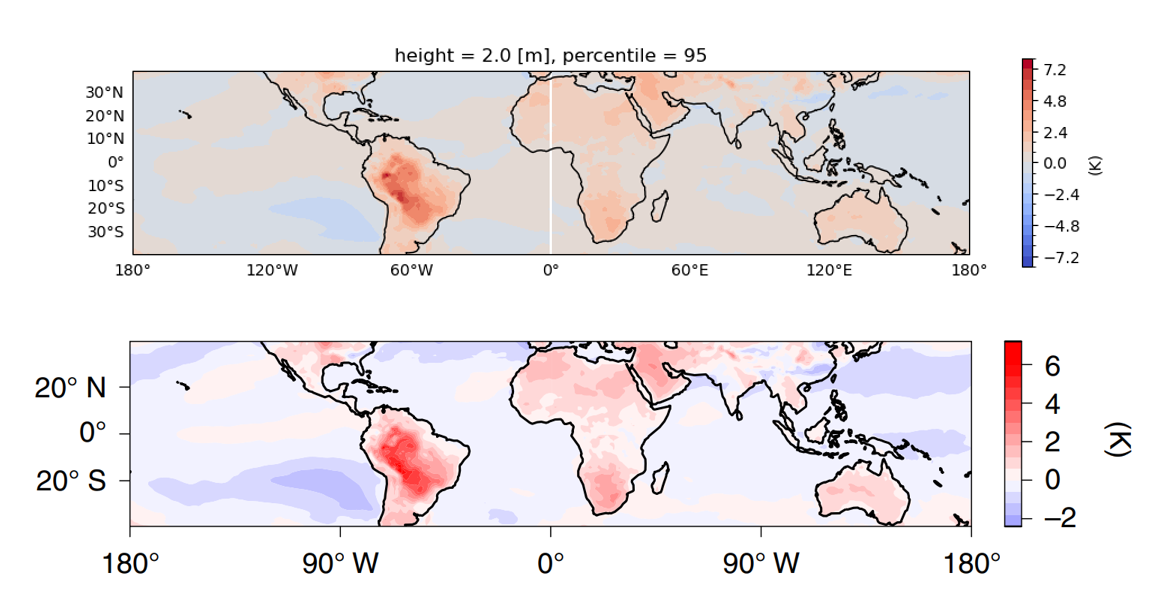

(top) Mine  (Bottom) Byrne 2021

- So they are pretty darn close - both for GFDL-CM4 - the difference between ssp245 and historical simulation
- the change averaged over the hottest 5% of days - not the temperature the 95th percentile sits at. Additionally its described as the anomaly from the zonal mean warming (zonal is latitude bands)
- One weird thing is the missing value down the 0 line - that happens with some of the models - not sure whats going on there

Overall Id say this is a pass for me - sanity checked

---
##### Figure 2 Byrne 2021

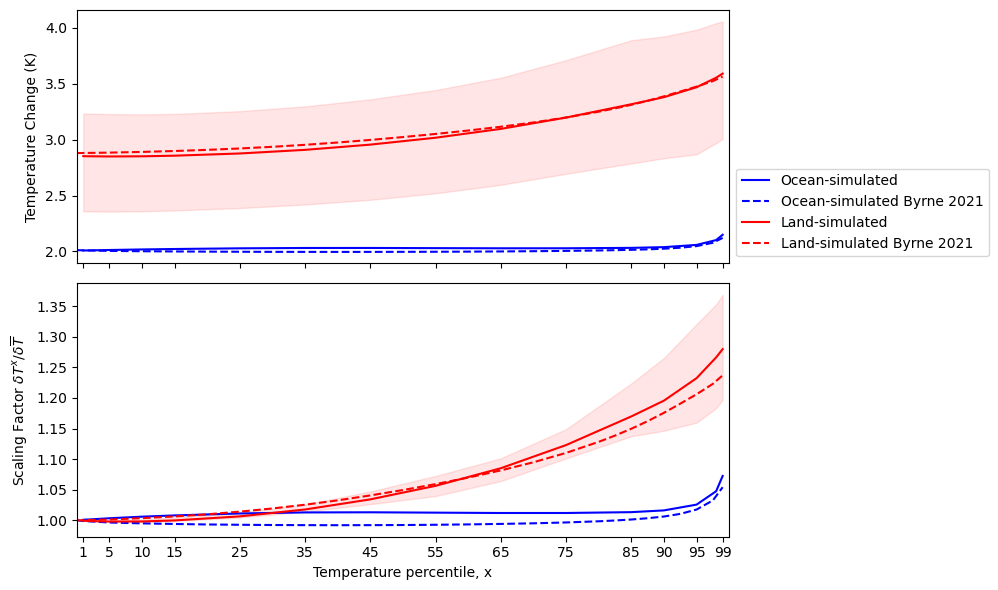

This one discribes the temperature change between ssp245 and historical simulations (top) as well as the regional scaling factor (bottom) averaged over days exceeding the xth percentile of land or ocean temperature. shaded region is 50% of the models
- I grabbed the lines from the 2021 paper to make sanity checking easier and we can see that they roughly line up
- I initially made the mistake of doing this figure in a different method: finding the change in mean over percentiles for every grid box and then averaged the response across grid boxes of a given region which substantially flattened the extreme temp tail but was sort of interesting
- Additionally the scaling factor is defined as the temperature change at each percentile $\delta T^x$ normalized by the mean temperature change $\delta \overline{T}$ which I thought was confusing as it leaves out the regional component of this

This one is a little more up for debate as to why there are differences here? - not sure I'm fully sold - especially on the bottom scaling factor - seems a little off but I need to figure out why

---
## Implimenting The fixed Relative Humitdity version of the Theory

This is the simplified version of the theory assuming a fixed RH over land:

$\delta T_L^x = \gamma ^{T_O} \delta T_O$


$\gamma ^{T_O} = \dfrac{(c_p + L_v \alpha_O q_O)}{(c_p + L_v \alpha _L q_L^x)}$

With...

$ \alpha _L = \dfrac{(\dfrac{\delta q_{L.sat}^x}{q_{L.sat}^x})}{\delta T_L^x}  $      

$ \alpha _O = \dfrac{(\dfrac{\delta q_{O.sat}}{q_{O.sat}})}{\delta T_O} $

$ \alpha _L $ is the clausius clapeyron parameters defining the fractional sensitvities of land saturation specific humidities to a 1 K temperature change

---
##### Calculating Saturation Specific Humidities
$$q^* = \dfrac{\epsilon \cdot e^*}{P - e \cdot (1-\epsilon)}$$
where
- $\epsilon$ = 0.622
- $e^* = Aexp(\alpha T)$
    - A = 611Pa and $\alpha$ = 0.0067C
- P = pressure at sealevel (I wouldve rather used surface pressure but not included)
    - potentially use monthly for ps

I got this from a university of hawaii website might want a better reference: https://pressbooks-dev.oer.hawaii.edu/atmo/chapter/chapter-4-water-vapor/ 

---
##### Calculating $\alpha _O$  and  $\alpha _L$

<details><summary>$ \alpha _O = \dfrac{(\dfrac{\delta q_{O.sat}}{q_{O.sat}})}{\delta T_O} $</summary>



$\delta T_O$
- just the full mean difference between ssp245 and historical for the ocean

$q_O.sat$
- the mean value of q_sat for the ocean in the historical simulation

$\delta q_O.sat$
- the difference in the mean q_sat for the ocean between ssp245 and historical simulations (all dims avgs.)

---
</details> 

<details><summary>$ \alpha _L = \dfrac{(\dfrac{\delta q_{L.sat}^x}{q_{L.sat}^x})}{\delta T_L^x}  $</summary>

$\delta T_L^x$
- the difference in the mean temperature of days exceeding the xth percentile between ssp245 and historical simulations for a list of percentiles


$q_{L.sat}^x$
- the mean specific humiditiy of land days where the temperature of those days exceeds the xth percentile of temperature for a list of percentiles

$\delta q_{L.sat}^x$
- the difference in mean specific humiditiy of land days where the temperature of those days exceeds the xth percentile of temperature between ssp245 and historical simulations for a list of percentiles
---

</details> 

**Note**: the values for $\alpha _O$  and  $\alpha _L$ are calculated model specific and $\alpha _L$ is calculated for each percentile of temperature
- this might come back to bite you

---
##### Calculating $\gamma ^{T_O}$

$\gamma ^{T_O} = \dfrac{(c_p + L_v \alpha_O q_O)}{(c_p + L_v \alpha _L q_L^x)}$


where:
- $c_p$ = 1004.6 J kg-1 K-1
- $L_v$ = 2500000 J kg-1
- $\alpha _O$ is calculated model specific
- $\alpha _L$ is claculated model and percentile specific - so really it should be $\alpha _L(p^x)$
- $q_O$ is the mean specific humidity of the ocean in the historical simulation
- $q_L^x$ is the mean specific humidity of land on days where temperature exceeds the xth percentile in the historic simulation

So all of these variables are calculated individually by model
- its possible I'm not meant to vary $\alpha_L$ by temp percentile and allow all the variation to come from $q_L^x$

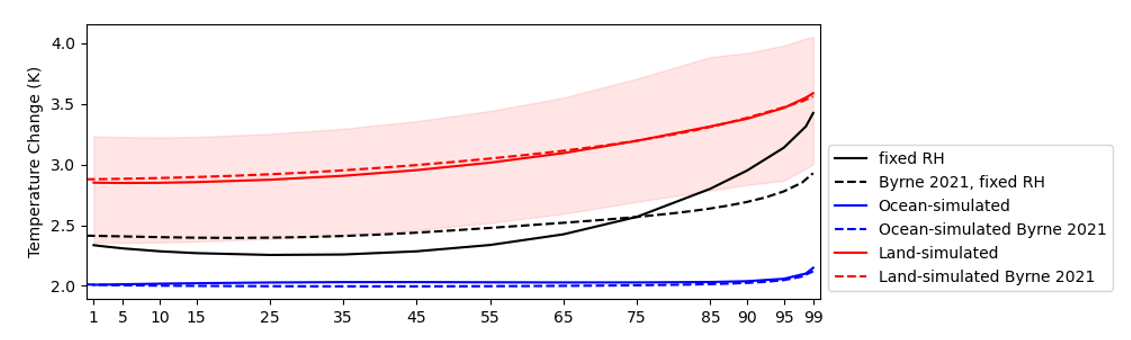

Solid black line is my calculation of the fixed RH theory 

Implimenting this shows that we done messed up somewhere...


--- 
### My Guess of what I need to change to get fixed RH theory to align:


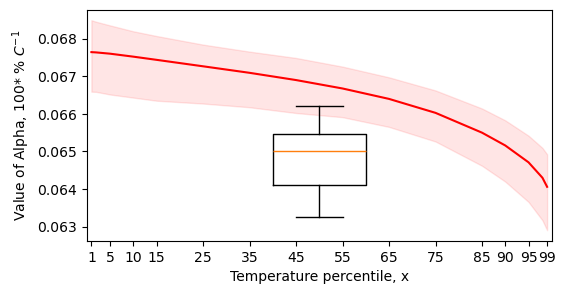

graph of the value of $\alpha_L$ across temperature percentiles (red line)

And the BAW plot is the spread of model values for $\alpha_O$

Looking above and thinking about the value of $\alpha _L$ (the red line):
- At low xth percentile -> $\alpha _L$ is greater
- At high xth percentile -> $\alpha _L$ is lesser

Additionally we know about $q_L^x$:
- At low xth percentile $q_L^x$ will be greater
- At high xth percentile $q_L^x$ will be lesser - due to these hot days getting drier

Thinking back to the calculation of gamma: (knowing $dT_L^x$ scales linearly with gamma)

$\gamma ^{T_O} = \dfrac{(c_p + L_v \alpha_O q_O)}{(c_p + L_v \alpha _L q_L^x)}$

- At low xth percentile the denominator is larger resulting in a smaller value of $\gamma ^{T_O}$
- At high xth percentile the denominator is smaller resulting in a larger value of $\gamma ^{T_O}$

This might have the above effect on the $dT_L^x$ predicted by the fixed RH theory ie that the high percentile tail would be too high and the low percentile tail would be too low (compared to if you kept $\alpha_L$ a constant value)


<details>
    
<summary> 
    ## More exploration into this...
</summary>

    
When you use the mean value for $\alpha_L$ across all model and all percentiles you get this 
    
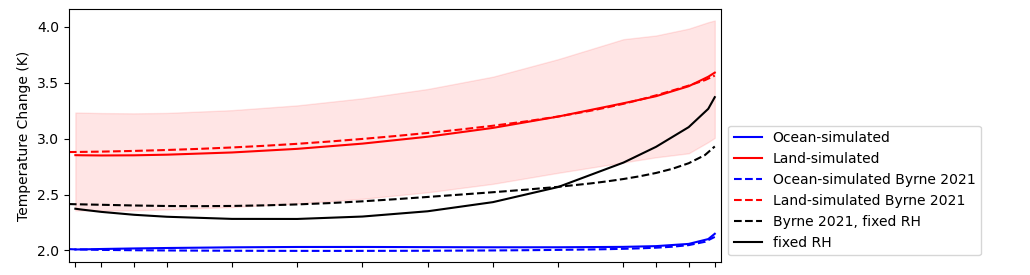

which might be slightly closer?

When the calculation is done with the model specific mean value for alpha there is also minimal difference in the shape

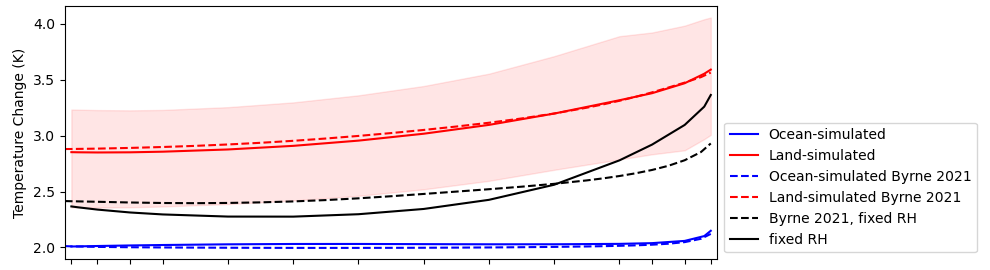


**This didnt seem to matter at all...**
- going to try and recreate additional figure 6 to see if it might be a problem with specific humidity

</details>

---
### Even with possible complication with calculating Gamma we can compare the simulated vs calculated with the fixed RH theory:
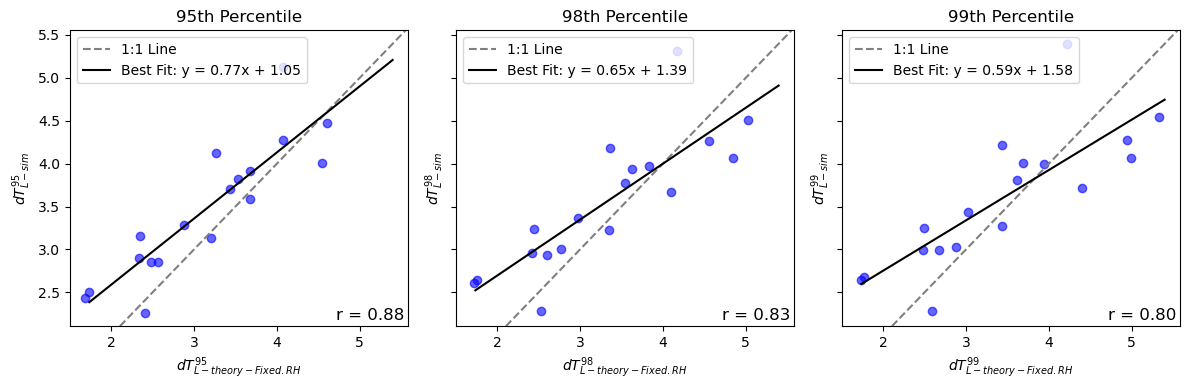

Once again we can't be too suprised by the slightly more gental slope to all this bc of high percentiles of temperature would have higher values for Gamma and thus be predicting higher values for the theory

---
## Next Steps

Need to discuss what you can and can't use in the predictor (ie what do you have to parmeterize)
- alpha values are calculated using delta vars
- additionally you can't estimate $dT_L^x$ without a solid contribution from $dT_O$ - however you could predict from the scaling factor of those days - ie basically just what Gamma should be vs what gamma is calculated to have been
- A little confused here but hopefully we can talk it through
- At somepoint the idea of removing the seasonal cycle is going to come up so it might be wise to build in the infrastructure sooner rather than later

Gotta figure out if the above section on why my fixed RH estimate isn't quite lining up 
- just takes some time for the code to run through

ERA5 - will need to build up infrastructure there to get estimates of gamma for the current climate which will be some work

Don't know if I should tackel the full theory yet or take this through to emergent constraint stuff first

I need to write up a brief research discription for pure and send it over to the powers that be - can I run that past you?

Initially we were also thinking of calculating the theory for each land grid point - I didn't see the point of doing that but its likely bc I missed the point rather than there not being one

In talking to some of the other first years they are doing courses to build some skills - is there anything I should be looking into?

---
---
---
## Take Aways for next meeting:
##### Latitudinal and land fraction weighting

$$\overline{T_L^x} = \dfrac{ \sum_{\phi} T_L^x(\phi) \cdot cos \phi \cdot f_L(\phi)  }{\sum_{\phi} cos \phi \cdot f_L(\phi)}$$

where: 
- $\phi$ - refers to each zonal band
- $f_L(\phi)$ - is the fraction of land within a latitudinal band

Quote from the Methods section: "Percentiles are computed at each latitude individually by aggregating
daily-mean quantities over time and longitude. Before plotting, quantities are
averaged from 20 °S to 20 °N with area weighting. Percentiles over land and ocean
are calculated separately"


##### Aproximate forms of $\alpha$ parameterts from Held and Soden 2006

$$\alpha(T) = \dfrac{d\ln e_s}{dT} = \dfrac{L}{R_vT^2} \therefore$$

$$\dfrac{1}{e_s} \dfrac{de_s}{dT} = \dfrac{\delta e_s}{e_s} = \dfrac{L}{R_vT^2} \delta T$$

The final piece of this just says that the fractional rate of change of saturation specific vapor pressure for a one degree change in temperature can be well estimated as a function of temperature

---
### Applying weighting to $\delta T^x_{rg}$ calculations

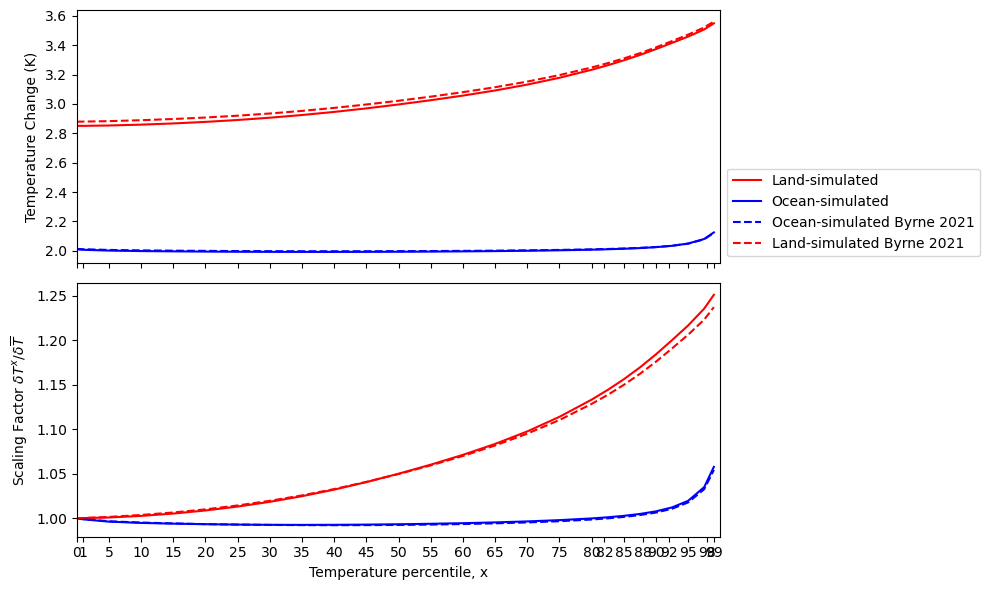